## 데이콘 비트코인 가격 예측 - Neural Prophet pilot

### library install & import, data load

In [1]:
# !pip install neuralprophet

In [4]:
# import library
import math
import os
import gc
import time
from datetime import timedelta, datetime
from dateutil import parser
import copy
import random as ran
import datetime

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# model
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(777)

# read file
train_x_df = pd.read_csv("./data/train_x_df.csv")
train_y_df = pd.read_csv("./data/train_y_df.csv")
print("Reading Complete!")



Reading Complete!


### data preprocess functions

In [106]:
def df2d_to_array3d(df_2d):

    ''' 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수 '''

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

def plot_series(train_x_df, train_y_df):
    
    ''' 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 함수 '''
    
    plt.plot(train_x_df, label = 'input_series')
    plt.plot(np.arange(len(train_x_df), len(train_x_df)+len(train_y_df)),
             train_y_df, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

### data reshaping

In [130]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)

idx = 7657 #coin num = 9, sammple id = 7657 
data_col_idx = 1 # 1 open, 2 high

# open 가격만 가지고 arima 시행
x_series = train_x_array[idx,:,data_col_idx] 
y_series = train_y_array[idx,:,data_col_idx]

print(f'''

train_x_array {x_series.shape}
train_y_array {y_series.shape}

''')



train_x_array (1380,)
train_y_array (120,)




### data preprocess for prophet

In [132]:

start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

# datafram 만들기
x_df = pd.DataFrame()
# 분당 시간 데이터 시리즈 입력
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
# 가격 데이터 시리즈 입력
x_df['y'] = x_series.tolist()

# x_df.head()

### modeling1 - original prophet drive

In [133]:
m = NeuralProphet(
    seasonality_mode = 'multiplicative',
    n_changepoints= 10, # changepoint_prior_scale, in original prophet
    changepoints_range=0.90, 
)

m.add_seasonality(name='first_seasonality', period=1/12, fourier_order=7) # seasonality 추가
m.add_seasonality(name='second_seasonality', period=1/8, fourier_order=15) # seasonality 추가

metrics = m.fit(x_df, freq="min")
future = m.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[46/46]: 100%|█| 46/46 [00:04<00:00,  9.47it/s, SmoothL1Loss=0.00975, MAE=0.00174, RegL


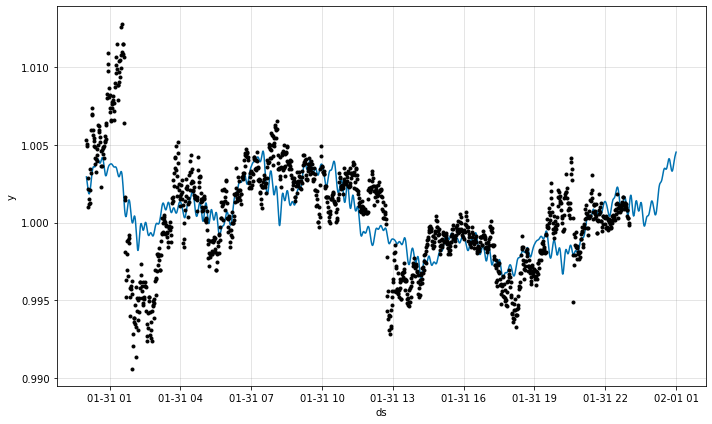

In [134]:
# fig = m.plot_components(forecast, residuals=True)
# fig2 = m.plot_parameters()
fig1 = m.plot(forecast)

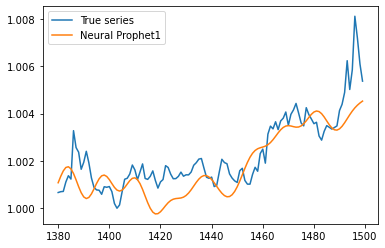

In [135]:
plt.plot(np.arange(1380, 1380+120), y_series, label = 'True series')
plt.plot(np.arange(1380, 1380+120), forecast.yhat1.values[-120:], label = 'Neural Prophet1')
plt.legend()
plt.show()

error = mean_squared_error(y_series, forecast.yhat1.values[-120:])
print("Prophet MSE*10E5 is {}".format(error * 10E5))


In [137]:
error = mean_squared_error(y_series, forecast.yhat1.values[-120:])
print("Prophet MSE*10E5 is {}".format(error * 10E5))


Prophet MSE*10E5 is 0.9410592763418618


### modeling2 - neural prophet drive with seasonality_reg

In [184]:
m = NeuralProphet(
    seasonality_mode = 'multiplicative',
    n_changepoints= 10, # changepoint_prior_scale, in original prophet
    seasonality_reg = 0.1, #seasonality regularization, 좀 더 선형적으로 그려줌
    changepoints_range=0.90, 
    
)

m.add_seasonality(name='first_seasonality', period=1/12, fourier_order=7) # seasonality 추가
m.add_seasonality(name='second_seasonality', period=1/8, fourier_order=15) # seasonality 추가

metrics = m.fit(x_df, freq="min")
future = m.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
forecast = m.predict(future)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[46/46]: 100%|█| 46/46 [00:04<00:00,  9.22it/s, SmoothL1Loss=0.00966, MAE=0.00173, RegL


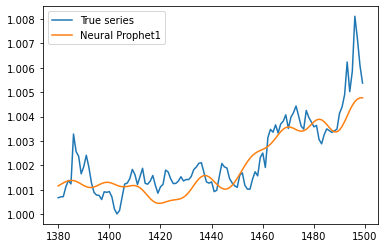

Prophet MSE*10E5 is 0.6396943151780092


In [185]:
plt.plot(np.arange(1380, 1380+120), y_series, label = 'True series')
plt.plot(np.arange(1380, 1380+120), forecast.yhat1.values[-120:], label = 'Neural Prophet1')
plt.legend()
plt.show()

error = mean_squared_error(y_series, forecast.yhat1.values[-120:])
print("Prophet MSE*10E5 is {}".format(error * 10E5))


### modeling3 - neural prophet drive using AR-Net -> 구닥다리...

In [229]:
m = NeuralProphet(
#     # trend & seasonal
#     seasonality_mode="multiplicative",
#     n_changepoints=10,
#     seasonality_reg=0.1,
#     changepoints_range=0.9,
    
    # AR-Net
    n_forecasts= 120,
    n_lags= 240,
    
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    
    num_hidden_layers=2,
)

metrics = m.fit(x_df, freq="min")
future = m.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
Epoch[46/46]: 100%|█| 46/46 [00:15<00:00,  2.92it/s, SmoothL1Loss=0.00206, MAE=0.000818, Smo


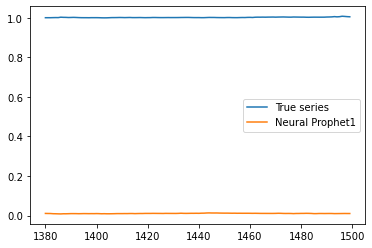

Prophet MSE*10E5 is 983474.6284859496


In [237]:
plt.plot(np.arange(1380, 1380+120), y_series, label = 'True series')
plt.plot(np.arange(1380, 1380+120), forecast.ar120.values[-120:], label = 'Neural Prophet1') # ar120 으로 해야함 기존 yhat이 아니라.
plt.legend()
plt.show()

error = mean_squared_error(y_series, forecast.ar120.values[-120:])
print("Prophet MSE*10E5 is {}".format(error * 10E5))
